In [2]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import math
import gc
from matplotlib import pyplot as plt

In [3]:
train=pd.read_csv("./data/Train.csv")
test=pd.read_csv("./data/Test.csv")
sample_sub=pd.read_csv("./data/sample_sub.csv")

In [4]:
print(np.shape(train))
print(np.shape(test))
print(np.shape(sample_sub))

(15539, 9)
(5035, 8)
(5035, 2)


In [5]:
# covert features  from string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature]=test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])  
    
# Create Features:
    # Create minmax features for each of the 6 types
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]

data=pd.concat([train,test],sort=False).reset_index(drop=True)
data.columns.tolist()

for col_name in tqdm(features):
    data[col_name]=data[col_name].apply(remove_nan_values)
    
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)
    
# Create time entries for each of the 6 types
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]
    
    
data.drop(features,1,inplace=True)
train=data[data.target.notnull()].reset_index(drop=True)
test=data[data.target.isna()].reset_index(drop=True)

del data  
gc.collect()

# Remove Target and ID columns from dataframe and assign targets to its own vector
train_targets = train['target']
train_pure = train.drop(columns=['target','ID','min_precip','median_precip'])
# The precip values are removed as they are all 0. Completely useless info and waste of resources.


# Convert Location ID's to numerical encodings
train_pure['location'] = train_pure['location'].replace(to_replace = ['A','B','C','D','E'], value = [1,2,3,4,5])

# Convert Pandas to Numpy for ease of Normalisation & Replacing of Nans
trn = train_pure.to_numpy()
# Up to this point the code runs quick. Hence I split the cells. 



100%|██████████| 6/6 [00:36<00:00,  6.14s/it]


In [5]:
# Replace Nans with mean column (feature) value
ivals = np.arange(trn.shape[0])
jvals = np.arange(trn.shape[1])

    # Replace nan by mean value of the column (ignoring nans)
    
    ###############################################################################################
    # USE THIS TO REPLACE NANS IN THE TESTING SET AS WELL!!!
meanvals = np.nanmean(trn,axis = 0)
    ###############################################################################################
for i in ivals:
    if i%1000 == 0:
        print(i) # Just helps visualise that something is actually happening
    for j in jvals:
        if np.isnan(trn[i,j]):
            trn[i,j] = meanvals[j] # Replace nan with the column mean value

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


/Users/lukevaneyk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


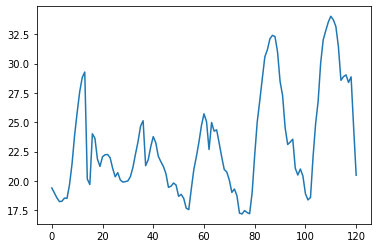

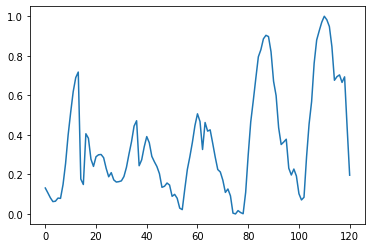

In [132]:
# Regroup Data
trn_not_conv = trn[:,0:-726]
trn_temp = trn[:,-726:]
trn_regrouped = np.zeros((trn_temp.shape))


trn_regrouped[:,0:121] = trn_temp[:,0::6]   # Temp
trn_regrouped[:,121:242] = trn_temp[:,1::6] # Prec
trn_regrouped[:,242:363] = trn_temp[:,2::6] # Humidity
trn_regrouped[:,363:484] = trn_temp[:,3::6] # Wind Dir
trn_regrouped[:,484:605] = trn_temp[:,4::6] # Wind Speed
trn_regrouped[:,605:726] = trn_temp[:,5::6] # Atm Pressure






# Normalise inputs using a safety margin for potential test set outliers
padding_factor = 0.0 # Percentage padding to add to the columns in case of outliers in real world predictions
trn_norm_ts = np.zeros((trn_regrouped.shape)) # Create normalised matrix for ts- time series
trn_norm_feat = np.zeros((trn_not_conv.shape)) # Create normalised matrix for feat- features
# Fill the matrices

# Normalise Time Series 1 by 1 
tempMax = np.max(trn_regrouped[:,0:121],axis = 1).reshape(15539,1)
tempMin = np.min(trn_regrouped[:,0:121],axis = 1).reshape(15539,1)
trn_norm_ts[:,0:121] = (trn_regrouped[:,0:121] - tempMin)/(tempMax*(1+padding_factor) - tempMin)


tempMax = np.max(trn_regrouped[:,121:242],axis = 1).reshape(15539,1)
tempMin = np.min(trn_regrouped[:,121:242],axis = 1).reshape(15539,1)
trn_norm_ts[:,121:242] = (trn_regrouped[:,121:242]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

tempMax = np.max(trn_regrouped[:,242:363],axis = 1).reshape(15539,1)
tempMin = np.min(trn_regrouped[:,242:363],axis = 1).reshape(15539,1)
trn_norm_ts[:,242:363] = (trn_regrouped[:,242:363]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

tempMax = np.max(trn_regrouped[:,363:484],axis = 1).reshape(15539,1)
tempMin = np.min(trn_regrouped[:,363:484],axis = 1).reshape(15539,1)
trn_norm_ts[:,363:484] = (trn_regrouped[:,363:484]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

tempMax = np.max(trn_regrouped[:,484:605],axis = 1).reshape(15539,1)
tempMin = np.min(trn_regrouped[:,484:605],axis = 1).reshape(15539,1)
trn_norm_ts[:,484:605] = (trn_regrouped[:,484:605]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

tempMax = np.max(trn_regrouped[:,605:726],axis = 1).reshape(15539,1)
tempMin = np.min(trn_regrouped[:,605:726],axis = 1).reshape(15539,1)
trn_norm_ts[:,605:726] = (trn_regrouped[:,605:726]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

# Normalise Features
trn_norm_feat = (trn_not_conv- np.min(trn_not_conv, axis = 0))/ (np.max(trn_not_conv, axis = 0)- np.min(trn_not_conv, axis = 0))

# Test Scaling
plt.figure()
plt.plot(trn_regrouped[10,0:121])
plt.figure()
plt.plot(trn_norm_ts[10,0:121])


(15539, 726)
(15539, 121, 6)


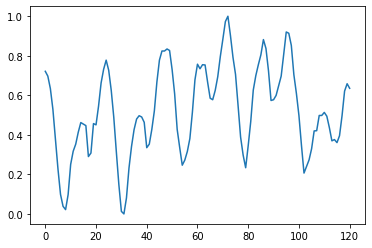

In [128]:
# (Ax1, Ax2, Ax3)
# Ax1 = Samples
# Ax2 = Time series, i.e. 121
# Ax3 = Features, i.e. 6

print(trn_norm_ts.shape)

X = np.reshape(trn_norm_ts,(np.shape(trn_norm_ts)[0],6,121))
X = X.transpose(0,2,1)

print(np.shape(X))

plt.plot(X[5,:,5])

In [134]:
# from numpy import save

# # To be safe, replace all possible nans due to the scaling:
# X = np.nan_to_num(X)
# trn_norm_feat = np.nan_to_num(trn_norm_feat)
# train_targets = np.nan_to_num(train_targets)


# save('Train1.npy', X)
# save('Train2.npy',trn_norm_feat)
# save('Train_targets.npy',train_targets)

In [135]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

58.24242947814752
475.82


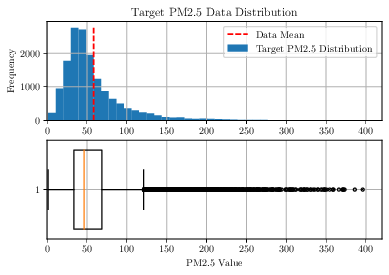

In [136]:
print(np.mean(train_targets))
print(np.max(train_targets))

plt.figure()
plt.subplot(2,1,1)
plt.title('Target PM2.5 Data Distribution')
plt.hist(train_targets, label = 'Target PM2.5 Distribution', bins = 50)
plt.plot([np.mean(train_targets),np.mean(train_targets)], [0,2800], 'r--', label = 'Data Mean')
plt.grid()
plt.legend()
plt.ylabel('Frequency')
plt.xlim([0,420])


plt.subplot(2,1,2)
plt.boxplot(train_targets, sym = 'k.', vert = False, widths = 0.8)
plt.grid()
plt.xlim([0,420])
plt.xlabel('PM2.5 Value')
plt.savefig('Figures/TargetDist.pgf')

(15539, 121, 6)
(15539, 41)


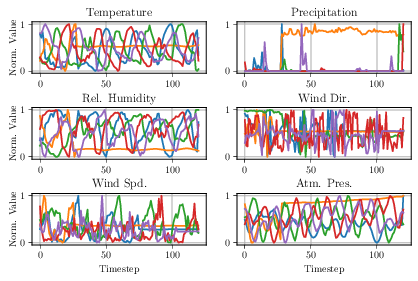

In [137]:
print(X.shape)
print(trn_not_conv.shape)

plt.figure()
feat_title = ['Temperature','Precipitation','Rel. Humidity','Wind Dir.','Wind Spd.','Atm. Pres.']
for f in range(len(feat_title)):
    plt.subplot(3,2,int(f+1))
    plt.tight_layout(h_pad=0.4)
    plt.grid()
    feature = f
    plt.title(feat_title[f])
    # Location A
    cursamp = 2
    plt.plot(X[cursamp,:,feature], label = 'Location A')

    # Location B
    cursamp = 9
    plt.plot(X[cursamp,:,feature], label = 'Location B')

    # Location C
    cursamp = 6
    plt.plot(X[cursamp,:,feature], label = 'Location C')

    # Location D
    cursamp = 1
    plt.plot(X[cursamp,:,feature], label = 'Location D')

    # Location E
    cursamp = 5
    plt.plot(X[cursamp,:,feature], label = 'Location E')

#     plt.legend()

    if f%2 == 0:
        plt.ylabel('Norm. Value')
        
    if f == 4 or f == 5:
        plt.xlabel('Timestep')

plt.savefig('Figures/TrainTrend.pgf')
        
# Blue = A
# Orange = B
# Green = C
# Red = D
# Purple = E

In [7]:
test_pure = test.drop(columns=['ID','target','min_precip','median_precip']) 
test_pure['location'] = test_pure['location'].replace(to_replace = ['A','B','C','D','E'], value = [1,2,3,4,5])
tst = test_pure.to_numpy()

# Replace Nans with mean column (feature) value
ivals = np.arange(tst.shape[0])
jvals = np.arange(tst.shape[1])

    # Replace nan by mean value of the column (ignoring nans)
    
    ###############################################################################################
    # USE THIS TO REPLACE NANS IN THE TESTING SET AS WELL!!!
meanvals = np.nanmean(tst,axis = 0)
    ###############################################################################################
for i in ivals:
    if i%1000 == 0:
        print(i) # Just helps visualise that something is actually happening
    for j in jvals:
        if np.isnan(trn[i,j]):
            tst[i,j] = meanvals[j] # Replace nan with the column mean value
        

0
1000
2000
3000
4000
5000


/Users/lukevaneyk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


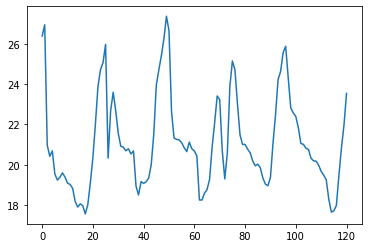

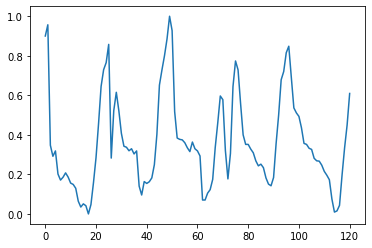

In [9]:
# Regroup Data
tst_not_conv = tst[:,0:-726]
tst_temp = tst[:,-726:]
tst_regrouped = np.zeros((tst_temp.shape))


tst_regrouped[:,0:121] = tst_temp[:,0::6]   # Temp
tst_regrouped[:,121:242] = tst_temp[:,1::6] # Prec
tst_regrouped[:,242:363] = tst_temp[:,2::6] # Humidity
tst_regrouped[:,363:484] = tst_temp[:,3::6] # Wind Dir
tst_regrouped[:,484:605] = tst_temp[:,4::6] # Wind Speed
tst_regrouped[:,605:726] = tst_temp[:,5::6] # Atm Pressure






# Normalise inputs using a safety margin for potential test set outliers
padding_factor = 0.0 # Percentage padding to add to the columns in case of outliers in real world predictions
tst_norm_ts = np.zeros((tst_regrouped.shape)) # Create normalised matrix for ts- time series
tst_norm_feat = np.zeros((tst_not_conv.shape)) # Create normalised matrix for feat- features
# Fill the matrices

# Normalise Time Series 1 by 1 
tempMax = np.max(tst_regrouped[:,0:121],axis = 1).reshape(5035,1)
tempMin = np.min(tst_regrouped[:,0:121],axis = 1).reshape(5035,1)
tst_norm_ts[:,0:121] = (tst_regrouped[:,0:121] - tempMin)/(tempMax*(1+padding_factor) - tempMin)


tempMax = np.max(tst_regrouped[:,121:242],axis = 1).reshape(5035,1)
tempMin = np.min(tst_regrouped[:,121:242],axis = 1).reshape(5035,1)
tst_norm_ts[:,121:242] = (tst_regrouped[:,121:242]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

tempMax = np.max(tst_regrouped[:,242:363],axis = 1).reshape(5035,1)
tempMin = np.min(tst_regrouped[:,242:363],axis = 1).reshape(5035,1)
tst_norm_ts[:,242:363] = (tst_regrouped[:,242:363]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

tempMax = np.max(tst_regrouped[:,363:484],axis = 1).reshape(5035,1)
tempMin = np.min(tst_regrouped[:,363:484],axis = 1).reshape(5035,1)
tst_norm_ts[:,363:484] = (tst_regrouped[:,363:484]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

tempMax = np.max(tst_regrouped[:,484:605],axis = 1).reshape(5035,1)
tempMin = np.min(tst_regrouped[:,484:605],axis = 1).reshape(5035,1)
tst_norm_ts[:,484:605] = (tst_regrouped[:,484:605]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

tempMax = np.max(tst_regrouped[:,605:726],axis = 1).reshape(5035,1)
tempMin = np.min(tst_regrouped[:,605:726],axis = 1).reshape(5035,1)
tst_norm_ts[:,605:726] = (tst_regrouped[:,605:726]-tempMin)/(tempMax*(1+padding_factor) - tempMin) 

# Normalise Features
tst_norm_feat = (tst_not_conv- np.min(tst_not_conv, axis = 0))/ (np.max(tst_not_conv, axis = 0)- np.min(tst_not_conv, axis = 0))

# Test Scaling
plt.figure()
plt.plot(tst_regrouped[10,0:121])
plt.figure()
plt.plot(tst_norm_ts[10,0:121])

(5035, 726)
(5035, 121, 6)


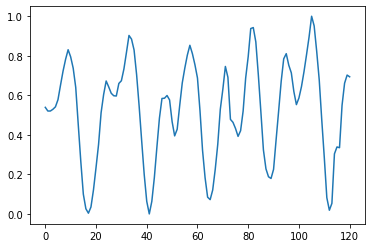

In [11]:
print(tst_norm_ts.shape)

Xt = np.reshape(tst_norm_ts,(np.shape(tst_norm_ts)[0],6,121))
Xt = Xt.transpose(0,2,1)

print(np.shape(Xt))

plt.plot(Xt[5,:,5])

In [13]:
# from numpy import save
# Xt = np.nan_to_num(Xt)
# tst_norm_feat = np.nan_to_num(tst_norm_feat)

# save('Test1.npy', Xt)
# save('Test2.npy',tst_norm_feat)